# Acoustic Anomaly Detection with Azure Machine Learning
## 8. Anomaly Sound Classification - audio features

<img src="https://github.com/retkowsky/Audio_Analytics_With_AzureML/raw/main/image.jpg" width = 800>

<div class="alert alert-info"><b> We will discover how Librosa can extract audio features from a single audio file.</b></div>

Serge Retkowsky | serge.retkowsky@microsoft.com | 31-May-2022 | V2

In [1]:
%matplotlib inline  
import librosa
import librosa.display
import IPython
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
audio = "test/machine_KO.wav"

In [3]:
extension = os.path.splitext(audio)[1][1:]
dirname = os.path.dirname(audio)
basename = os.path.basename(audio)

file_df = pd.DataFrame({'file': [audio]})
ext_df = pd.DataFrame({'extension': [extension]})
dirname_df = pd.DataFrame({'dir': [dirname]})
basename_df = pd.DataFrame({'basename': [basename]})
filename_df = pd.concat([file_df, dirname_df, basename_df, ext_df], axis=1)
filename_df

,file,dir,basename,extension
0,test/machine_KO.wav,test,machine_KO.wav,wav


### Audio Overview

In [4]:
y, sr = librosa.load(audio)

In [5]:
sr

22050

In [6]:
IPython.display.Audio(audio)

In [7]:
print('Audio Sampling Rate:', sr, 'samples per second')
print('Total Samples:', np.size(y))
duration = np.size(y) / sr
print('Duration =', duration)

Audio Sampling Rate: 22050 samples per second
Total Samples: 154350
Duration = 7.0


## Feature Extraction

To determine the music genre of a music piece, a
number of content-based features are first extracted. In
general, the features employed for music classification can
be roughly categorized into three classes: timbral texture,
rhythmic features, and pitch content features. 

Timbral features are generally characterized by the properties
related to instrumentations or sound sources such as music,
speech, or environment signals. The features used to
represent the timbral texture of a music track include zero
crossing, spectral centroid, spectral flux, spectral rolloff,
Mel-frequency cepstral coefficients (MFCC),
Daubechies wavelet coefficients histograms (DWCH),
and octave-based spectral contrast (OSC), etc. 

Rhythmic features provide the main beat and its strength of
a music track. Several beat-tracking algorithms have been
proposed to estimate the main beat and the corresponding
strength. Pitch features, mainly derived from the
pitch histogram, describe the melody of the music. 
### Separation of Harmonic and Percussive Signals

Text(0.5, 1.0, 'Separation of Harmonic and Percussive Signals')

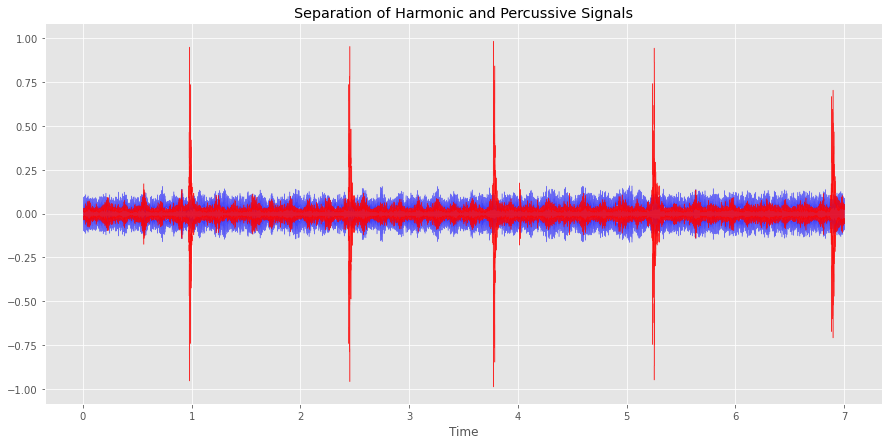

In [8]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

plt.figure(figsize = (15, 7))
plt.style.use('ggplot')
librosa.display.waveshow(y_harmonic, sr = sr, color = 'blue', alpha = 0.5)
librosa.display.waveshow(y_percussive, sr = sr, color = 'red', alpha = 0.8)
plt.title('Separation of Harmonic and Percussive Signals')

### 1. Beat Extraction
The output of the beat tracker is an estimate of the tempo (in beats per minute), and an array of frame numbers corresponding to detected beat events.

Frames here correspond to short windows of the signal (y), each separated by hop_length = 512 samples. Since v0.3, librosa uses centered frames, so that the kth frame is centered around sample k 

We will use the average tempo of the song as a feature.

In [9]:
tempo, beat_frames = librosa.beat.beat_track(y = y_harmonic, sr = sr)
print('Tempo =', tempo)

Tempo = 89.10290948275862


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Beats')

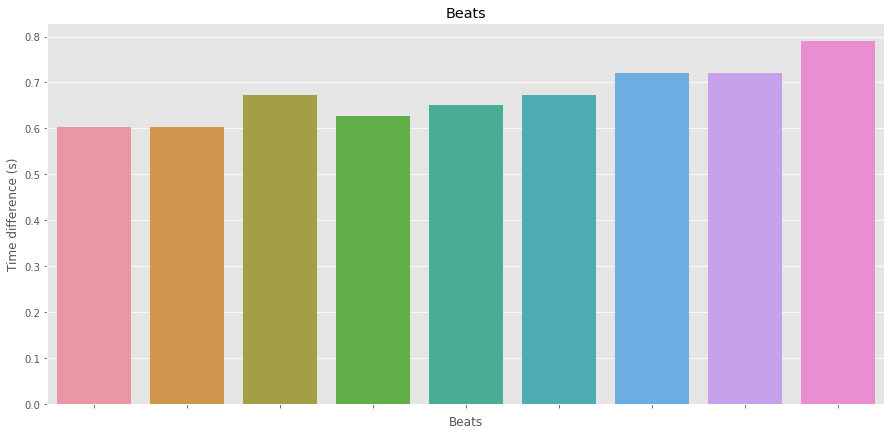

In [10]:
beat_times = librosa.frames_to_time(beat_frames, sr = sr)
beat_time_diff=np.ediff1d(beat_times)
beat_nums = np.arange(1, np.size(beat_times))

plt.style.use('ggplot')
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)
ax.set_ylabel("Time difference (s)")
ax.set_xlabel("Beats")
g = sns.barplot(beat_nums, beat_time_diff, ax = ax)
g = g.set(xticklabels = [])
plt.title('Beats')

### 2. Chroma Energy Normalized (CENS)

Calculate the Chroma Energy Normalized (CENS) for the audio file. A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).


Text(0.5, 1.0, 'Chroma Energy Normalized (CENS)')

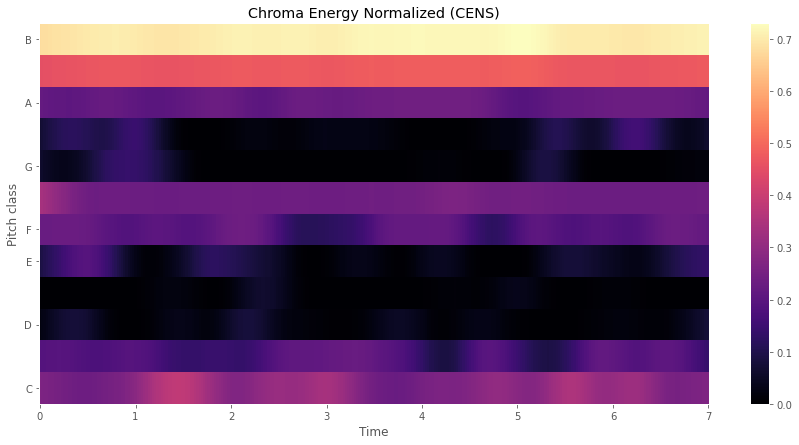

In [11]:
chroma = librosa.feature.chroma_cens(y = y_harmonic, sr = sr)

plt.figure(figsize = (15, 7))
librosa.display.specshow(chroma,y_axis = 'chroma', x_axis = 'time')
plt.colorbar()
plt.title('Chroma Energy Normalized (CENS)')

### 3. Calculate MFCCs

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

Text(0.5, 1.0, 'MFCC')

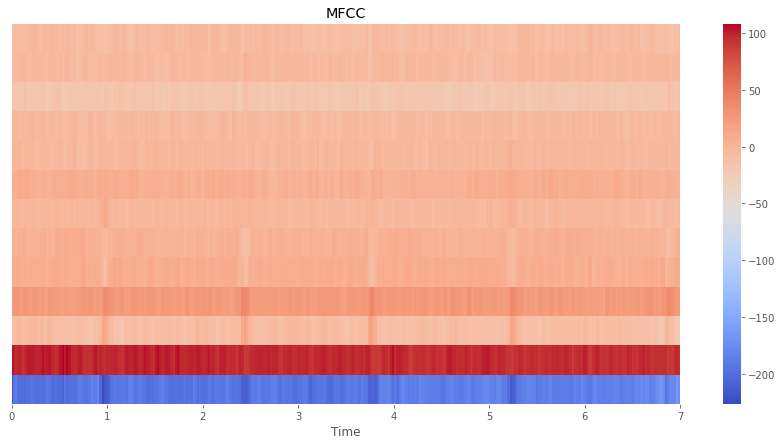

In [12]:
mfccs = librosa.feature.mfcc(y = y_harmonic, sr = sr, n_mfcc = 13)

plt.figure(figsize = (15, 7))
librosa.display.specshow(mfccs, x_axis = 'time')
plt.colorbar()
plt.title('MFCC')

### 4. Spectral Centroid

The spectral centroid is a metric used to characterize the spectra of music. It is a geometric indicator of the position of the center of mass of the spectrum of a sound.

In the study of musical timbres we sometimes speak of brightness, many consider this characteristic to be one of the most discriminating factors between music. It is an indicator of the amount of high frequencies that make up the sound. And the spectral centroid is a reliable way to measure this characteristic

Text(0.5, 1.0, 'Spectral centroid')

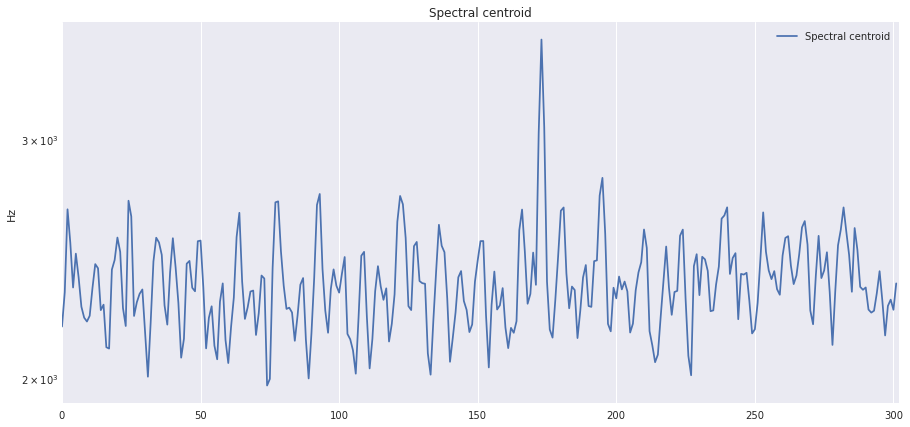

In [13]:
cent = librosa.feature.spectral_centroid(y = y, sr = sr)

plt.style.use('seaborn')
plt.figure(figsize = (15, 7))
plt.semilogy(cent.T, label = 'Spectral centroid')

plt.ylabel('Hz')
plt.xlim([0, cent.shape[-1]])
plt.legend()
plt.title('Spectral centroid')

### 5. Spectral Contrast

OSC was developed to represent the spectral characteristics
of a music piece. It considers the spectral peak and valley in
each sub-band separately. In general, spectral peaks
correspond to harmonic components and spectral valleys
correspond to non-harmonic components or noise in a
music piece. Therefore, the difference between spectral
peaks and spectral valleys will reflect the spectral contrast
distribution. 

Text(0.5, 1.0, 'Spectral contrast')

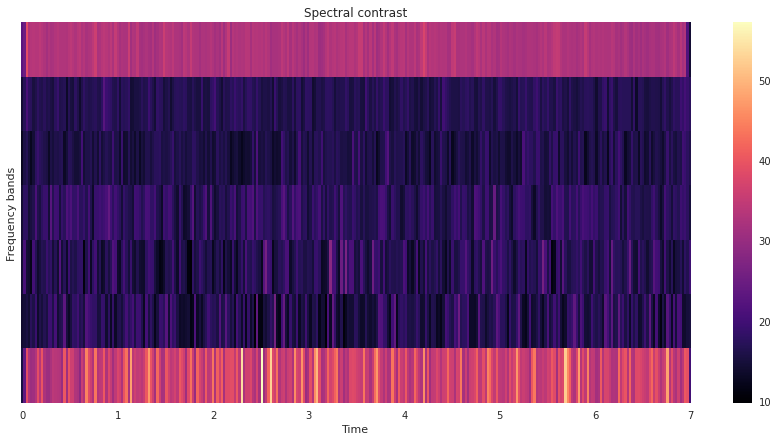

In [14]:
contrast = librosa.feature.spectral_contrast(y = y_harmonic, sr = sr)

plt.figure(figsize = (15, 7))
librosa.display.specshow(contrast, x_axis = 'time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral contrast')

### 6. Spectral Rolloff

This feature is a measure of the right-side asymmetry of a sound spectrum. It is used for example to differentiate between sung and normal lyrics

Text(0.5, 1.0, 'Spectral rolloff')

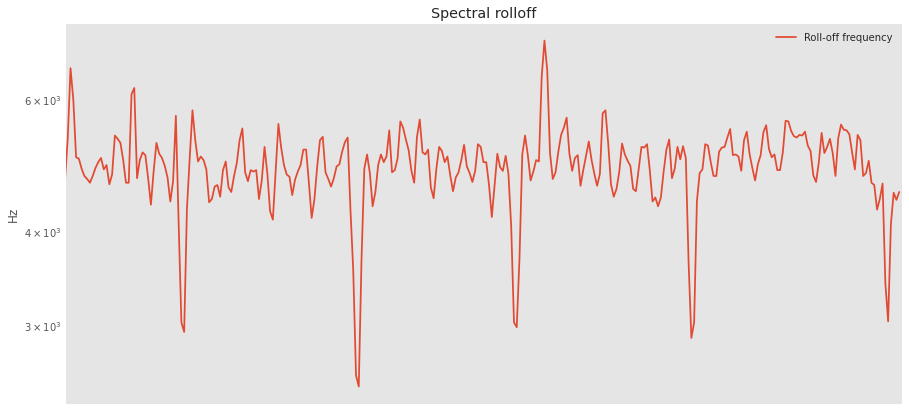

In [15]:
rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr)

plt.style.use('ggplot')
plt.figure(figsize = (15, 7))
plt.semilogy(rolloff.T, label = 'Roll-off frequency')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend()
plt.title('Spectral rolloff')

### 7. Zero Crossing Rate


The ZCR is an indicator proportional to the rate of sign change of a musical signal. It is widely used for speech recognition and seems to be an interesting criterion for music classification.

In general, this metric is very used as soon as we have a signal with a temporal evolution. In our case we take 0 as value, but can adapt the metric to positive signals by translation.

Text(0.5, 1.0, 'zero crossing rate')

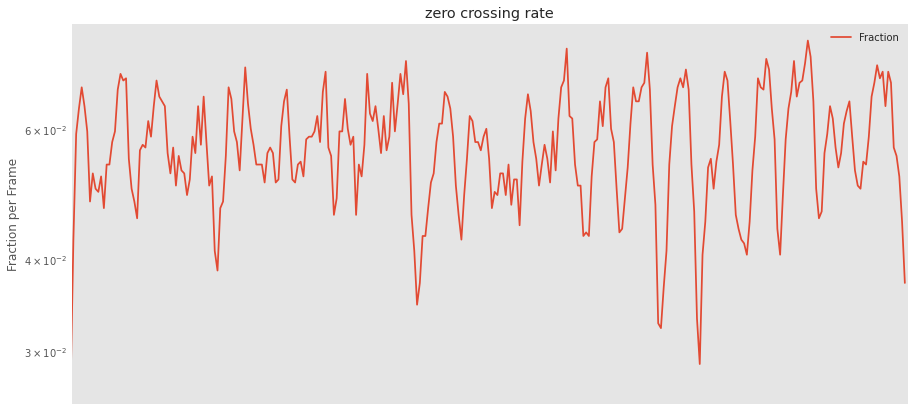

In [16]:
zrate = librosa.feature.zero_crossing_rate(y_harmonic)

plt.figure(figsize = (15, 7))
plt.style.use('ggplot')
plt.semilogy(zrate.T, label = 'Fraction')
plt.ylabel('Fraction per Frame')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend()
plt.title('zero crossing rate')

## Feature Generation

This section will use the features extracted in the previous section and generate summary features for the entire song.

### 1. Chroma Energy Normalized

The output of CENS contains the 12 element representation of the chroma energy thoroughout the song. The 12 element each will be summarized using mean and standard deviation accross the entire song.


,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,...,chroma_std_2,chroma_std_3,chroma_std_4,chroma_std_5,chroma_std_6,chroma_std_7,chroma_std_8,chroma_std_9,chroma_std_10,chroma_std_11
0,0.289983,0.171279,0.025673,0.010201,0.05855,0.191344,0.241428,0.026686,0.052729,0.222546,...,0.021651,0.014725,0.049552,0.034386,0.016311,0.039884,0.047043,0.01273,0.007398,0.011097


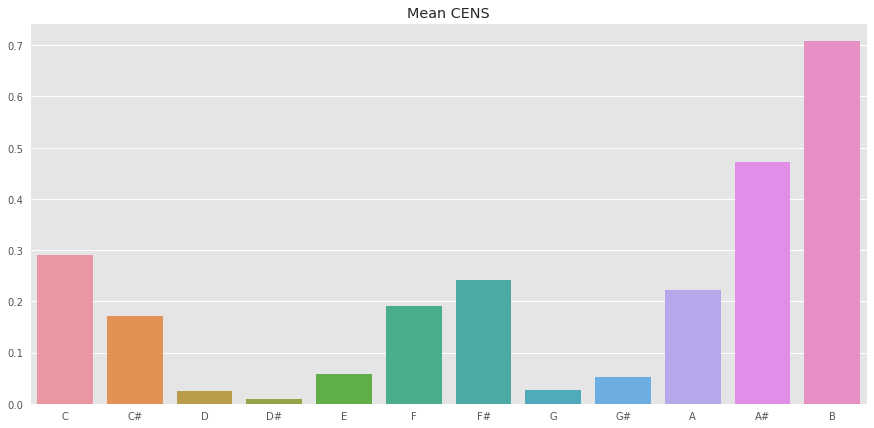

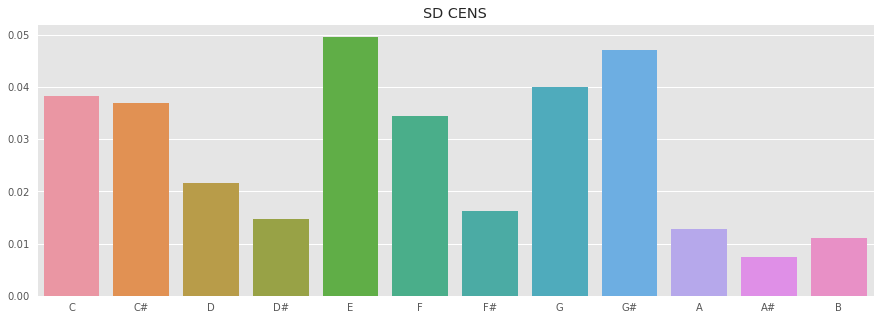

In [17]:
chroma_mean = np.mean(chroma, axis=1)
chroma_std = np.std(chroma, axis=1)

octave = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
plt.figure(figsize = (15, 7))
plt.title('Mean CENS')
sns.barplot(x = octave, y = chroma_mean)

plt.figure(figsize = (15, 5))
plt.title('SD CENS')
sns.barplot(x = octave,y = chroma_std)

#Generate the chroma Dataframe
chroma_df = pd.DataFrame()

for i in range(0, 12):
    chroma_df['chroma_mean_' + str(i)] = chroma_mean[i]

for i in range(0, 12):
    chroma_df['chroma_std_' + str(i)] = chroma_mean[i]

chroma_df.loc[0] = np.concatenate((chroma_mean, chroma_std), axis=0)
chroma_df

### 2. MFCCs

To characterize the whole music
piece, the mean and standard deviation of MFCC of all
frames in a music piece are used as features. 

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,...,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12
0,-191.188477,96.606125,-8.484474,24.581018,6.316506,2.839086,-2.92308,5.035668,-3.459412,-5.402826,...,3.612216,3.612375,3.230783,2.885472,2.692183,2.672097,2.302306,2.592187,2.478417,2.769071


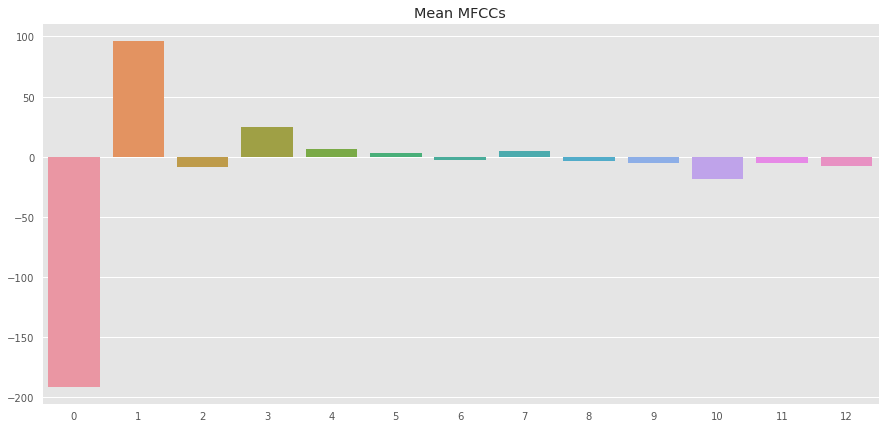

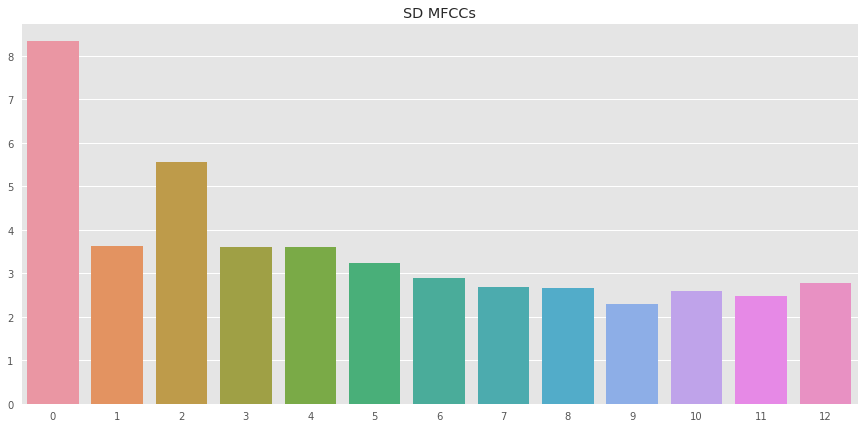

In [18]:
mfccs_mean = np.mean(mfccs, axis=1)
mfccs_std = np.std(mfccs, axis=1)

coeffs = np.arange(0, 13)
plt.figure(figsize = (15, 7))
plt.title('Mean MFCCs')
sns.barplot(x = coeffs, y = mfccs_mean)

plt.figure(figsize = (15, 7))
plt.title('SD MFCCs')
sns.barplot(x = coeffs,y = mfccs_std)

# Generate the chroma Dataframe
mfccs_df = pd.DataFrame()

for i in range(0, 13):
    mfccs_df['mfccs_mean_' + str(i)] = mfccs_mean[i]

for i in range(0, 13):
    mfccs_df['mfccs_std_' + str(i)] = mfccs_mean[i]

mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis = 0)
mfccs_df

### 3. Spectral Features

#### Spectral Centroid

In [19]:
cent_mean = np.mean(cent)
cent_std = np.std(cent)
cent_skew = scipy.stats.skew(cent, axis = 1)[0]
print('Mean:', cent_mean)
print('SD:', cent_std)
print('Skewness:', cent_skew)

Mean: 2349.0474284595007
SD: 185.89320501691546
Skewness: 1.3041059087458478


#### Spectral Contrast

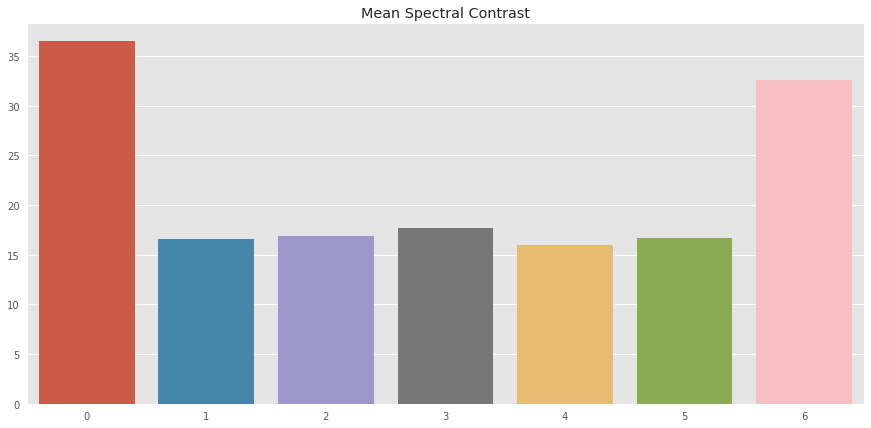

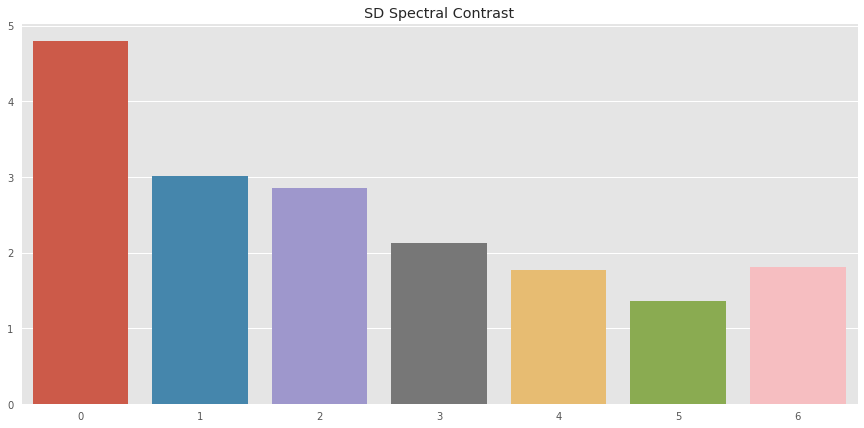

In [20]:
contrast_mean = np.mean(contrast, axis = 1)
contrast_std = np.std(contrast, axis = 1)
conts = np.arange(0, 7)

plt.figure(figsize = (15, 7))
plt.title('Mean Spectral Contrast')
sns.barplot(x = conts, y = contrast_mean)

plt.figure(figsize = (15, 7))
plt.title('SD Spectral Contrast')
sns.barplot(x = conts, y = contrast_std)
# Generate the chroma Dataframe
contrast_df=pd.DataFrame()

#### Spectral Rolloff

In [21]:
rolloff_mean = np.mean(rolloff)
rolloff_std = np.std(rolloff)
rolloff_skew = scipy.stats.skew(rolloff, axis = 1)[0]
print('Mean: '+ str(rolloff_mean))
print('SD: '+ str(rolloff_std))
print('Skewness: '+ str(rolloff_skew))

Mean: 4879.195661734271
SD: 560.7122092794145
Skewness: -0.9128652767987611


In [22]:
spectral_df = pd.DataFrame()
collist=['cent_mean', 'cent_std', 'cent_skew']

for i in range(0, 7):
    collist.append('contrast_mean_' + str(i))

for i in range(0, 7):
    collist.append('contrast_std_' + str(i))

collist = collist+['rolloff_mean', 'rolloff_std', 'rolloff_skew']

for c in collist:
    spectral_df[c] = 0

data=np.concatenate(([cent_mean, cent_std, cent_skew], contrast_mean, contrast_std,[rolloff_mean, rolloff_std,
                                                                                  rolloff_std]), axis=0)
spectral_df.loc[0] = data
spectral_df

,cent_mean,cent_std,cent_skew,contrast_mean_0,contrast_mean_1,contrast_mean_2,contrast_mean_3,contrast_mean_4,contrast_mean_5,contrast_mean_6,contrast_std_0,contrast_std_1,contrast_std_2,contrast_std_3,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew
0,2349.047428,185.893205,1.304106,36.484649,16.589368,16.875361,17.653329,15.940355,16.669534,32.605223,4.79068,3.014502,2.856063,2.128508,1.767149,1.353295,1.810802,4879.195662,560.712209,560.712209


### 4. Zero Crossing Rate

In [23]:
zrate_mean = np.mean(zrate)
zrate_std = np.std(zrate)
zrate_skew = scipy.stats.skew(zrate, axis = 1)[0]

print('Mean: '+ str(zrate_mean))
print('SD: '+ str(zrate_std))
print('Skewness: '+ str(zrate_skew))

Mean: 0.056936504035596025
SD: 0.009480711502170397
Skewness: -0.25713519152159725


In [24]:
zrate_df = pd.DataFrame()
zrate_df['zrate_mean'] = 0
zrate_df['zrate_std'] = 0
zrate_df['zrate_skew'] = 0
zrate_df.loc[0] = [zrate_mean, zrate_std, zrate_skew]
zrate_df

,zrate_mean,zrate_std,zrate_skew
0,0.056937,0.009481,-0.257135


### 5. Beat and Tempo

In [25]:
beat_df = pd.DataFrame()
beat_df['tempo'] = tempo
beat_df.loc[0] = tempo
print('Tempo =', beat_df.at[0, 'tempo'])

Tempo = 89.10290948275862


## Generate the Final DF

In [26]:
sr_df = pd.DataFrame({'sampling_rate': [sr]})
totalsamples = np.size(y)
duration = totalsamples / sr
totalsamples_df = pd.DataFrame({'total_samples': [totalsamples]})
duration_df = pd.DataFrame({'duration': [duration]})

In [27]:
audiofeatures_df = pd.concat((chroma_df, mfccs_df, spectral_df, zrate_df, beat_df), axis = 1)
filesaudio_df = pd.concat([filename_df, sr_df, totalsamples_df, duration_df, audiofeatures_df], axis = 1)

In [28]:
filesaudio_df.head()

,file,dir,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,chroma_mean_1,chroma_mean_2,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,test/machine_KO.wav,test,machine_KO.wav,wav,22050,154350,7.0,0.289983,0.171279,0.025673,...,1.767149,1.353295,1.810802,4879.195662,560.712209,560.712209,0.056937,0.009481,-0.257135,89.102909


In [29]:
filesaudio_df.shape

(1, 81)

In [30]:
filesaudio_df

,file,dir,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,chroma_mean_1,chroma_mean_2,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,test/machine_KO.wav,test,machine_KO.wav,wav,22050,154350,7.0,0.289983,0.171279,0.025673,...,1.767149,1.353295,1.810802,4879.195662,560.712209,560.712209,0.056937,0.009481,-0.257135,89.102909


> You can run the next notebook

Note: All these Python notebooks were made for demo purposes. They were not designed for production usage. Some feature can be currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews. https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/
